#### COMP 215 - Project 01

# Plotting Potentially Hazardous Near Earth Objects

#### Name: Ben Blair
#### Date: 27/02/2023

## Project Description
This application allows the user to plot the close-approach record for the near earth objects in a given date range.

Note: All data is pulled from NASA's Near Earth Object Web Service (NeoWs).

## Instructions

1.   Start by running the 'Import' code block below.
2.   Set your parameters and run the code block.
3.   Run all remaining code blocks.
4.   Scroll all the way to the bottom to view the display.



## Import

In [10]:
# Import the necessary modules
import datetime, json, requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the API key
API_KEY = 'GT5a6VBQVVTnT8H1jSPfja2DfDMaC1d0UsYeWsYW'

# Define the possible approach bodies
APPROACH_BODIES = {
    'Merc'  : 'Mercury',
    'Venus' : 'Venus',
    'Earth' : 'Earth',
    'Mars'  : 'Mars',
    'Juptr' : 'Jupiter',
    'Satrn' : 'Saturn',
    'Urnus' : 'Uranus',
    'Neptn' : 'Neptune',
    'Pluto' : 'Pluto',
    'Moon'  : 'Moon'
}

## Set the Parameters

`search_start`: Start date for the search period.
> *Valid inputs: any date of the form YYYY-MM-DD between* `1900-01-01` *and* `2200-01-01`

`search_end`: End date for the search period.
> *Valid inputs: any date of the form YYYY-MM-DD between* `1900-01-01` *and* `2200-01-01`

`disp_start`: Start date for the display period.
> *Valid inputs: any date of the form YYYY-MM-DD between* `1900-01-01` *and* `2200-01-01`

`disp_end`: End date for the display period.
> *Valid inputs: any date of the form YYYY-MM-DD between* `1900-01-01` *and* `2200-01-01`

`approach_body`: The celestial body approached by the NEO.
> *Valid inputs:* `Merc`, `Venus`, `Earth`, `Mars`, `Juptr`, `Satrn`, `Urnus`, `Neptn`, `Pluto`, `Moon`

`only_hazardous`: `True` displays only NEOs identified as potentially hazardous while `False` displays all NEOs.
> *Valid inputs:* `True` *or* `False`

In [11]:
# Define the parameters
search_start = '2023-02-13'
search_end = '2023-02-15'

disp_start = '1900-01-01'
disp_end = '2200-01-01'

approach_body = 'Juptr'

only_hazardous = False

## Query the NASA Database

In [12]:
url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={search_start}&end_date={search_end}&api_key={API_KEY}'
response = requests.request("GET", url, headers={}, data={})
data = json.loads(response.text)

In [13]:
n_neos = data['element_count']
neos = [neo for day in data['near_earth_objects'] for neo in data['near_earth_objects'][day]]

## Get Only Hazardous NEOs

In [14]:
hazardous_ids = [neo['id'] for neo in neos if neo['is_potentially_hazardous_asteroid'] == True]
n_hazardous = len(hazardous_ids)

if only_hazardous == True:
    neo_ids = hazardous_ids
else:
    neo_ids = [neo['id'] for neo in neos]

## Fetch Orbital Data for Each NEO

In [15]:
def get_approach_data(id):
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}/?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    
    approach_dates = [datetime.date.fromisoformat(approach['close_approach_date']) for approach in data['close_approach_data'] if approach['orbiting_body'] == approach_body]
    miss_distances = [float(approach['miss_distance']['kilometers']) for approach in data['close_approach_data'] if approach['orbiting_body'] == approach_body]
    orbital_period = data['orbital_data']['orbital_period']

    if approach_dates == []:
        approach_data = None
    else:
        approach_data = {
            'approach_dates': approach_dates,
            'miss_distances': miss_distances,
            'orbital_period': orbital_period
        }
    
    return approach_data

In [16]:
approach_data = {id:get_approach_data(id) for id in neo_ids if get_approach_data(id) is not None}
approach_ids = [id for id in approach_data]
n_approach = len(approach_data)

## Plot the NEO Data

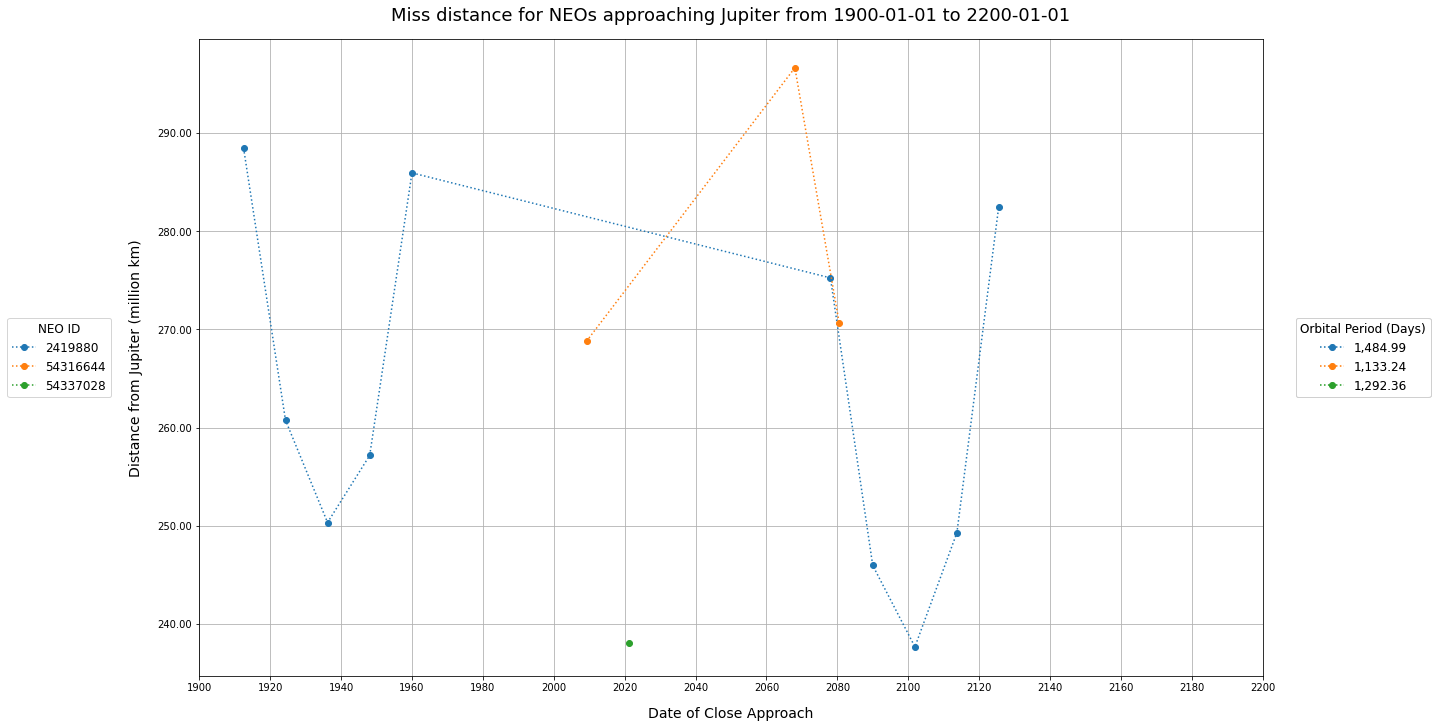


Summary of search results:

62 near earth objects were detected during the search period from 2023-02-13 to 2023-02-15.
5 of the 62 detected NEOs are classified as potentially hazardous.
3 of the 5 potentially hazardous NEOs approach Jupiter between 1900-01-01 and 2200-01-01.


In [17]:
# Plot the close approach time series data for each NEO
fig, ax = plt.subplots(figsize=(16,10), layout='constrained')

ax.set_title(f'Miss distance for NEOs approaching {APPROACH_BODIES[approach_body]} from {disp_start} to {disp_end}', fontsize=18, pad=18)

ax.set_xlabel('Date of Close Approach', labelpad=14, fontsize=14)
ax.set_ylabel(f'Distance from {APPROACH_BODIES[approach_body]} (million km)', labelpad=14, fontsize=14)

# Lines 13-16 were adapted from matplotlib's guide 'Formatting date ticks using ConciseDateFormatter'
locator = mdates.AutoDateLocator(maxticks=25)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlim(left=datetime.date.fromisoformat(disp_start), right=datetime.date.fromisoformat(disp_end))

def million_km(x, pos):
    return f'{x*1e-6:,.2f}'

ax.yaxis.set_major_formatter(million_km)

ax.grid(visible=True, which='both')

for id in approach_data:
    x = approach_data[id]['approach_dates']
    y = approach_data[id]['miss_distances']
    orbital_period = float(approach_data[id]['orbital_period'])
    ax.plot(x, y, 'o', linestyle=':', label=f'{orbital_period:,.2f}')

# Create the legends and add them to the plot
legend_1 = ax.legend(labels=approach_ids, title='NEO ID', loc='center left', borderaxespad=-16, title_fontsize=12, fontsize=12)
legend_2 = ax.legend(title='Orbital Period (Days)', loc='center right', borderaxespad=-14, title_fontsize=12, fontsize=12)
ax.add_artist(legend_1)
ax.add_artist(legend_2)

plt.show()

# Display some information about the search results
print('\nSummary of search results:\n')
print(f'{n_neos} near earth objects were detected during the search period from {search_start} to {search_end}.')
print(f'{n_hazardous} of the {n_neos} detected NEOs are classified as potentially hazardous.')
print(f'{n_approach} of the {n_hazardous} potentially hazardous NEOs approach {APPROACH_BODIES[approach_body]} between 1900-01-01 and 2200-01-01.')

## Tips & Troubleshooting

*   The majority of close approaches for the NEOs in NASA's database are associated with Earth. As such, selecting other approach bodies will limit your search results.
*   If more than ten NEOs are displayed in the plot, their colors may be repeated in the legend and it could become difficult to distinguish between them. Try narrowing the search range or plotting only the hazardous NEOs to reduce the number of NEOs displayed in the plot.
*   Remember to 'Run all' (Ctrl+F9) each time you adjust the parameters of your search.
